#### DMML Assignment 2
##### Himanshu, MDS202327 and Suneet Patil, MCS202327

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

In [4]:
#Read the document file and converts the documents into vectors 
def readDoc(filename):
    fObj = open(filename, "r")
    numDoc = int(fObj.readline())
    numWord = int(fObj.readline())
    numLines = int(fObj.readline())
    docXword = np.zeros(shape=(numDoc+1,numWord+1), dtype='float16')
    for i in range(numLines):
        NNZ = fObj.readline().split(' ')
        [docID, wordID, count] = [int(x) for x in NNZ]
        if count != 0:
            docXword[docID][wordID] = 1         
    fObj.close()
    return docXword[1:,1:]

In [5]:
collectionEnron = readDoc('bag_of_words//docword.enron.txt')
collectionKos = readDoc('bag_of_words//docword.kos.txt')
collectionNips = readDoc('bag_of_words//docword.nips.txt')

In [5]:
# Calcualtes the Jaccard Distance of two sets
def jaccardDistance(A, B):
    return 1- (np.sum(np.logical_and(A, B)) / np.sum(np.logical_or(A, B)))

In [7]:
# Initializes the centroids using kmeans++ algorithm
def initializedCentroids(X, k):
    n,m = X.shape
    centroids = np.empty((k, m))
    centroids[0] = X[[np.random.randint(n)]]

    dist = pairwise_distances(X, centroids[:1], metric=jaccardDistance).flatten()

    for i in range(1, k):
        prob = dist ** 2
        prob /= prob.sum()
        next_centroid_index = np.random.choice(n, p=prob)
        centroids[i] = X[next_centroid_index]
        new_dist = pairwise_distances(X, centroids[i:i+1], metric=jaccardDistance).flatten()
        dist = np.minimum(dist, new_dist)

    return centroids

In [8]:
# Assigns labels to the documents based on the centroids
def getLabels(X, centroids, numDoc):
    labels = np.zeros(numDoc, dtype='int8')
    for i in range(numDoc):
        labels[i] = np.argmin([jaccardDistance(X[i],centroid) for centroid in centroids])
    return labels

In [9]:
# Calculates the centroids based on the labels
def getCentroids(X, labels, k, numWords, oldcent):
    result = np.empty((k,numWords), dtype='float16')
    for m in range(k):
        clusters = X[labels==m]
        if len(clusters) == 0:
            result[m] = oldcent[m]
        else:
            result[m] = np.mean(clusters)
    return result

In [10]:
# Calculates the sum of squared distances of the documents from the centroids
def ssdf(X,centroids, labels):
    ssd = 0
    for i,cent in enumerate(centroids):
        clusters = X[labels==i]
        if len(clusters)>0:
            ssd += np.sum(pairwise_distances(clusters, [cent], metric=jaccardDistance)**2)
    return ssd

In [12]:
# Kmeans++ algorithm
def kMeanspp(X, k, batch, init,max_iter=100):
    numWords = X.shape[1]
    xshape = X.shape[0]
    centroids = init
    iter = 0
    oldCentroids = None

    while (not np.array_equal(oldCentroids, centroids)) and iter < max_iter:
        batchX = X[np.random.choice(xshape, batch, replace=False)]
        numDoc =  batch
        oldCentroids = centroids.copy()
        labels = getLabels(batchX, centroids, numDoc)
        centroids = getCentroids(batchX, labels, k, numWords, oldCentroids)
        ssd = ssdf(batchX, centroids, labels)
        iter += 1

    return ssd

In [13]:
helpDict = {'collectionEnron':(collectionEnron, 1000), 'collectionKos':(collectionKos, 200), 'collectionNips':(collectionNips, 400)}

In [14]:
# Stores the results of the kmeans++ algorithm
def storeResults(data,k):
    X = helpDict[data][0]
    batch = helpDict[data][1]
    ssd = []
    for i in range(1,k):
        init = initializedCentroids(X, i+1)
        result = kMeanspp(X, i+1, batch, init)
        ssd.append(result)
    return ssd

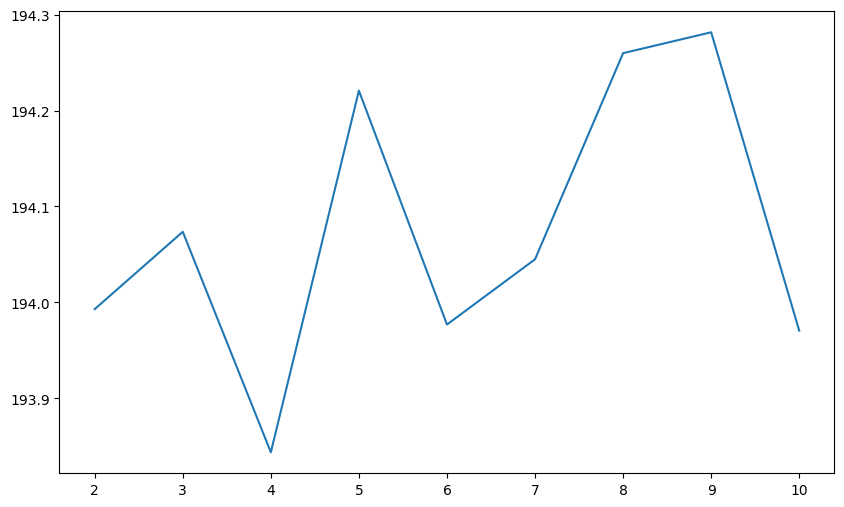

In [15]:
# Kos dataset
plt.figure(figsize=(10,6))
plt.plot(range(2,11), storeResults('collectionKos', 10))
plt.show()

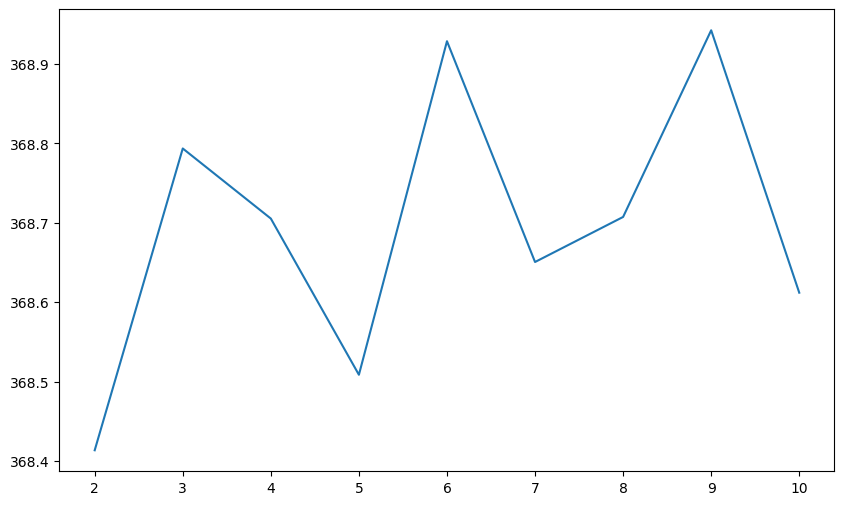

In [16]:
# Nips dataset
plt.figure(figsize=(10,6))
plt.plot(range(2,11), storeResults('collectionNips', 10))
plt.show()

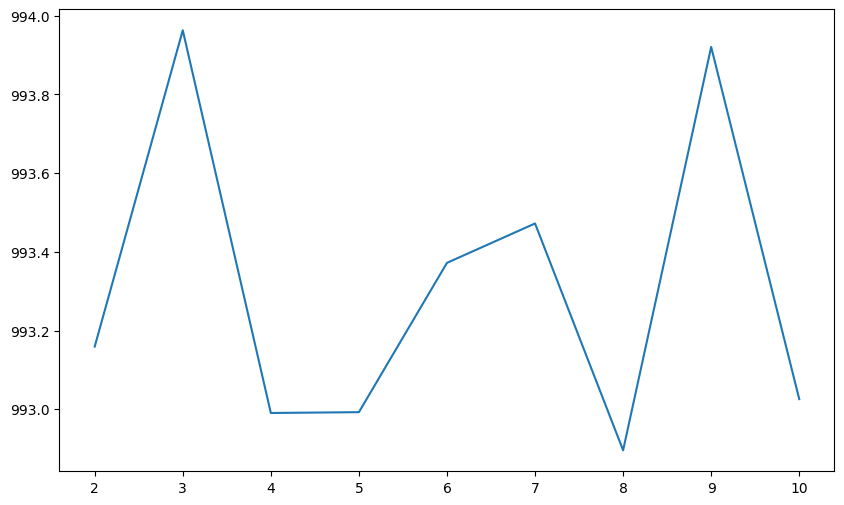

In [17]:
# Enron dataset
plt.figure(figsize=(10,6))
plt.plot(range(2,11), storeResults('collectionEnron', 10))
plt.show()